In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

Using cache found in C:\Users\ADMIN/.cache\torch\hub\pytorch_vision_v0.10.0


Files already downloaded and verified
Original Label: 3
New Prediction after One Pixel Attack: 841


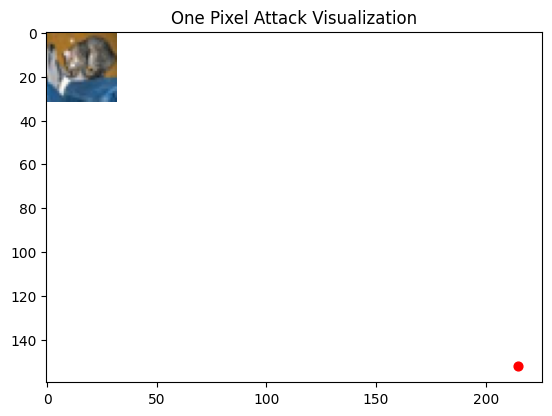

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import differential_evolution

# Load pre-trained ResNet18 model
def load_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    model.eval()
    return model

# Preprocess image for ResNet18
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet18 requires 224x224 input size
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Predict class for an image
def predict(model, image):
    with torch.no_grad():
        output = model(image)
    return torch.argmax(output, dim=1).item()

# Apply one-pixel attack
def attack(image, model, pixel_pos):
    perturbed_image = image.clone()
    perturbed_image[0, :, pixel_pos[0], pixel_pos[1]] = torch.tensor(pixel_pos[2:])
    return predict(model, perturbed_image)

# Objective function for optimization
def objective_function(pixel, image, model, target_class):
    new_class = attack(image, model, pixel.astype(int))
    return 1 if new_class == target_class else 0

# Differential Evolution to find the best pixel to modify
def one_pixel_attack(image, model, target_class):
    bounds = [(0, 224), (0, 224), (0, 1), (0, 1), (0, 1)]  # Pixel position (x, y) and RGB values
    result = differential_evolution(objective_function, bounds, args=(image, model, target_class), maxiter=100, popsize=10)
    return result.x

# Load model
model = load_model()

# Load CIFAR-10 dataset
image_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=None)  # No need for ToPILImage
image, label = image_dataset[0]  # Select the first image
image_tensor = preprocess_image(image)

# Target class (wrong label to fool the model)
target_class = 3

# Apply One-Pixel Attack
perturbation = one_pixel_attack(image_tensor, model, target_class)

# Print results
print("Original Label:", label)
print("New Prediction after One Pixel Attack:", predict(model, image_tensor))

# Visualize the attack
plt.imshow(image)
plt.scatter(perturbation[1], perturbation[0], c='red', s=40)  # Mark the modified pixel
plt.title("One Pixel Attack Visualization")
plt.show()
